#### App Initialization

In [220]:
# Import statements and app initialization
import pandas as pd
import numpy as np
import re
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [221]:
# Read loan csv
df_loan = pd.read_csv('loan.csv')

In [222]:
# Get loan columns
loan_columns = list(df_loan.columns)
loan_columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

#### Reusable Functions

In [223]:
def isna(value):
    try:
        return np.isnan(value)
    except:
        return False

def convert_percent_to_number(value, type='float', decimal_place=2):
    if type == 'float':
        return round(float(value.strip().rstrip('%')), decimal_place)
    else:
        return int(value.strip().rstrip('%'))

#### Fix Columns

##### Removing columns that has just 1 unique value. These columns cannot be driving variables and cannot help in analysis.

In [224]:
# Get columns that has 1 unique value count. These columns cannot be driving variables and cannot help us in analyzing so removing it

def get_columns_by_expected_unique_count(expected_unique_count = 1):
    result = []
    for column in loan_columns:
        unique_values = df_loan[column].unique()
        unique_count = len(unique_values)
        if unique_count == expected_unique_count:
            result.append(column)
    return result
    
loan_irrelevant_columns = get_columns_by_expected_unique_count(1)
loan_irrelevant_columns

['pymnt_plan',
 'initial_list_status',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_

In [225]:
# Removing irrelevant columns
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(loan_irrelevant_columns, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 111)
Shape after removing columns (39717, 51)


In [226]:
# Update loan columns variable
loan_columns = list(df_loan.columns)
loan_columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'pub_rec_bankruptcies',
 'tax_liens']

In [227]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [228]:
# As next_pymnt_d has only 2.28% non null values and mths_since_last_record has 7% non-null values, and these variables null values cannot be imputed
# thus they cannot be driving variable and cannot help us in analysis so removing these columns
# Removing irrelevant columns
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['next_pymnt_d', 'mths_since_last_record'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 51)
Shape after removing columns (39717, 49)


In [229]:
# Removing those columns as well where null values are greater than 50%. These columns cannot be driving variables and cannot help in overall analysis
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['mths_since_last_delinq'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 49)
Shape after removing columns (39717, 48)


In [230]:
# Removing columns that are neither categorical nor quantative. They cannot help us in analysis
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['desc'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 48)
Shape after removing columns (39717, 47)


In [231]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [232]:
# As we have to analyze for new customers applying for loan, so there are certain fields which we can remove as they will not be provided in the application
# This data will not be available when customer will apply for loan and bank cannot analyze customer profile based on these fields
fields_not_available_application_time = ['out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d']
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(fields_not_available_application_time, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 47)
Shape after removing columns (39717, 36)


In [233]:
# Even A grade customers are found to have high revolving utilization rate(revol_util) as such revol_util cannot help us in determining risk associated with new customers.
# Total credit accounts(total_acc) is not necessary as we are keeping open credit accounts (open_acc)
# Loan inquiries in last 6 month cannot help us in getting any insight of new customer(inq_last_6mths) so removing it
# Customer will not be able to provide delinquishments in last 2 year(delinq_2yrs) so removing it
# Removing title and emp_title as they cannot provide any insight on risk associated with new customer
# Removing revolving account balance as from revolving account balance(revol_bal) can be withdrawn and repay anytime. It can impact proper analysis. Instead of it keep outstanding principal which is fixed metric to get proper analysis
to_remove_columns = ['revol_util', 'total_acc', 'inq_last_6mths', 'delinq_2yrs', 'title', 'emp_title', 'revol_bal']
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(to_remove_columns, axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 36)
Shape after removing columns (39717, 29)


In [234]:
# pub_rec_bankruptcies has less relevant data as compare to pub_rec. So removing this column
print("Shape before removing columns {0}".format(df_loan.shape))
df_loan.drop(['pub_rec_bankruptcies'], axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (39717, 29)
Shape after removing columns (39717, 28)


#### Fix Rows

##### Handling rows having null columns.

In [235]:
# Maximum non-null rows are 39717. Checking which column has less non-null rows and figure out reason behind it.

In [236]:
# After latest update 2.7% of customers has null employee length. NULL employee length creates no meaning and it cannot be imputed as well, so removing
# records with null emp_length. As records are very small so it should the impact overall analysis.
df_loan = df_loan[~df_loan['emp_length'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38642 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38642 non-null  int64  
 1   member_id                   38642 non-null  int64  
 2   loan_amnt                   38642 non-null  int64  
 3   funded_amnt                 38642 non-null  int64  
 4   funded_amnt_inv             38642 non-null  float64
 5   term                        38642 non-null  object 
 6   int_rate                    38642 non-null  object 
 7   installment                 38642 non-null  float64
 8   grade                       38642 non-null  object 
 9   sub_grade                   38642 non-null  object 
 10  emp_length                  38642 non-null  object 
 11  home_ownership              38642 non-null  object 
 12  annual_inc                  38642 non-null  float64
 13  verification_status         38642 no

In [237]:
# As of the latest update, 0.14% of data has collections_12_mths_ex_med NULL. As this value cannot be imputed and cannot help us in analysis,
# we can remove rows having this column NULL value.
df_loan = df_loan[~df_loan['collections_12_mths_ex_med'].isnull()]
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38586 non-null  int64  
 1   member_id                   38586 non-null  int64  
 2   loan_amnt                   38586 non-null  int64  
 3   funded_amnt                 38586 non-null  int64  
 4   funded_amnt_inv             38586 non-null  float64
 5   term                        38586 non-null  object 
 6   int_rate                    38586 non-null  object 
 7   installment                 38586 non-null  float64
 8   grade                       38586 non-null  object 
 9   sub_grade                   38586 non-null  object 
 10  emp_length                  38586 non-null  object 
 11  home_ownership              38586 non-null  object 
 12  annual_inc                  38586 non-null  float64
 13  verification_status         38586 no

In [238]:
# Looking for duplicate rows. No duplicate row exist
df_loan[df_loan.duplicated()]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


In [239]:
# No unecessary header or footer rows in data. 
# All empty/blank rows must be removed in null value checks
# There are no column number indicator rows
# There are no total/sub-total rows

#### Fix Data type

In [240]:
# term is a categorical variable has only 2 possible values 36 month and 60 month. There values are wrongly formatted have spaces around them and
# we can just keep them integer and assume that term is in month only. 
def validate_term(value):
    return int(value.strip().rstrip('month').rstrip('months').strip())

df_loan['term'] = df_loan['term'].apply(validate_term)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38586 non-null  int64  
 1   member_id                   38586 non-null  int64  
 2   loan_amnt                   38586 non-null  int64  
 3   funded_amnt                 38586 non-null  int64  
 4   funded_amnt_inv             38586 non-null  float64
 5   term                        38586 non-null  int64  
 6   int_rate                    38586 non-null  object 
 7   installment                 38586 non-null  float64
 8   grade                       38586 non-null  object 
 9   sub_grade                   38586 non-null  object 
 10  emp_length                  38586 non-null  object 
 11  home_ownership              38586 non-null  object 
 12  annual_inc                  38586 non-null  float64
 13  verification_status         38586 no

In [241]:
# int_rate is a quantative variable. There values are wrongly formatted by keeping percent in the end
# we can convert it to float by removing percent. 
df_loan['int_rate'] = df_loan['int_rate'].apply(convert_percent_to_number)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38586 non-null  int64  
 1   member_id                   38586 non-null  int64  
 2   loan_amnt                   38586 non-null  int64  
 3   funded_amnt                 38586 non-null  int64  
 4   funded_amnt_inv             38586 non-null  float64
 5   term                        38586 non-null  int64  
 6   int_rate                    38586 non-null  float64
 7   installment                 38586 non-null  float64
 8   grade                       38586 non-null  object 
 9   sub_grade                   38586 non-null  object 
 10  emp_length                  38586 non-null  object 
 11  home_ownership              38586 non-null  object 
 12  annual_inc                  38586 non-null  float64
 13  verification_status         38586 no

In [242]:
# Converting date string field to datetime
#pd.to_datetime(df_loan['issue_d'])
#pd.to_datetime(df_loan['issue_d'], format='%b-%y')
df_loan['issue_d'] = pd.to_datetime(df_loan['issue_d'], format='%b-%y')
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          38586 non-null  int64         
 1   member_id                   38586 non-null  int64         
 2   loan_amnt                   38586 non-null  int64         
 3   funded_amnt                 38586 non-null  int64         
 4   funded_amnt_inv             38586 non-null  float64       
 5   term                        38586 non-null  int64         
 6   int_rate                    38586 non-null  float64       
 7   installment                 38586 non-null  float64       
 8   grade                       38586 non-null  object        
 9   sub_grade                   38586 non-null  object        
 10  emp_length                  38586 non-null  object        
 11  home_ownership              38586 non-null  object        


In [243]:
# Fixing type of earliest_cr_line
df_loan['earliest_cr_line'] = pd.to_datetime(df_loan['earliest_cr_line'], format='%b-%y')
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          38586 non-null  int64         
 1   member_id                   38586 non-null  int64         
 2   loan_amnt                   38586 non-null  int64         
 3   funded_amnt                 38586 non-null  int64         
 4   funded_amnt_inv             38586 non-null  float64       
 5   term                        38586 non-null  int64         
 6   int_rate                    38586 non-null  float64       
 7   installment                 38586 non-null  float64       
 8   grade                       38586 non-null  object        
 9   sub_grade                   38586 non-null  object        
 10  emp_length                  38586 non-null  object        
 11  home_ownership              38586 non-null  object        


In [244]:
# Setting correct type in emp_length
def convert_emp_length_valid_value(value):
    without_space = value.replace(' ', '')
    if without_space.startswith('<1'):
        return 0
    elif without_space.startswith('10+'):
        return 10
    else:
        return int(without_space.rstrip('year').rstrip('years'))

df_loan['emp_length'] = df_loan['emp_length'].apply(convert_emp_length_valid_value)
df_loan['emp_length'].unique()

array([10,  0,  1,  3,  8,  9,  4,  5,  6,  2,  7])

In [245]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38586 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          38586 non-null  int64         
 1   member_id                   38586 non-null  int64         
 2   loan_amnt                   38586 non-null  int64         
 3   funded_amnt                 38586 non-null  int64         
 4   funded_amnt_inv             38586 non-null  float64       
 5   term                        38586 non-null  int64         
 6   int_rate                    38586 non-null  float64       
 7   installment                 38586 non-null  float64       
 8   grade                       38586 non-null  object        
 9   sub_grade                   38586 non-null  object        
 10  emp_length                  38586 non-null  int64         
 11  home_ownership              38586 non-null  object        


In [246]:
# Rulling out all current status loan as they cannot provide any insight
df_loan = df_loan[df_loan['loan_status'] != 'Current']
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37488 entries, 0 to 39665
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          37488 non-null  int64         
 1   member_id                   37488 non-null  int64         
 2   loan_amnt                   37488 non-null  int64         
 3   funded_amnt                 37488 non-null  int64         
 4   funded_amnt_inv             37488 non-null  float64       
 5   term                        37488 non-null  int64         
 6   int_rate                    37488 non-null  float64       
 7   installment                 37488 non-null  float64       
 8   grade                       37488 non-null  object        
 9   sub_grade                   37488 non-null  object        
 10  emp_length                  37488 non-null  int64         
 11  home_ownership              37488 non-null  object        


In [247]:
# Standardization is not needed with given data. 

#### Fixing Invalid Values

In [248]:
# All zip codes follows expected format
list(filter(lambda x: not(re.search("^\d{3}xx$", x)), df_loan['zip_code'].unique()))

[]

In [249]:
# Removing invalid value from earliest_cr_line. earliest_cr_line contains value greater than current year which is not possible
current_year = datetime.datetime.now().year #get current year
print("Shape before removing rows {0}".format(df_loan.shape))
df_loan = df_loan[df_loan['earliest_cr_line'].dt.year <= current_year]
print("Shape before removing rows {0}".format(df_loan.shape))

Shape before removing rows (37488, 28)
Shape before removing rows (37429, 28)


In [250]:
# Valid as 0 rows as loan disbursed amount cannot be greater than loan amount(amount asked in application)
df_loan[df_loan['loan_amnt'] < df_loan['funded_amnt']]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


In [251]:
# Valid as 0 rows as loan disbursed amount by investor cannot be greater than loan amount(asked in application)
df_loan[df_loan['loan_amnt'] < df_loan['funded_amnt_inv']]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


In [252]:
# Valid as 0 rows as loan disbursed amount by investor cannot be greater than loan disbursed amount by bank
df_loan[df_loan['funded_amnt'] < df_loan['funded_amnt_inv']]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,out_prncp,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens


#### Final Cleaning

In [253]:
# After all above cleaning, it looks like there are no other invalid values in data.
# As a side-effect of cleaning, some columns emerge with only 1 unique value. Removing those columns, as these columns cannot help in analysis
print("Shape before removing columns {0}".format(df_loan.shape))
loan_columns = list(df_loan.columns)
print(get_columns_by_expected_unique_count(1))
df_loan.drop(get_columns_by_expected_unique_count(1), axis=1, inplace=True)
print("Shape after removing columns {0}".format(df_loan.shape))

Shape before removing columns (37429, 28)
['out_prncp', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens']
Shape after removing columns (37429, 24)


In [254]:
# Removing those columns which cannot help in analysis as they are neither categorical nor quantative variables. These variables can neither help
# in segmented univariant analysis and nor in bivariant analysis
df_loan.drop(['url', 'id', 'member_id'], axis=1, inplace=True)
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37429 entries, 0 to 39665
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loan_amnt            37429 non-null  int64         
 1   funded_amnt          37429 non-null  int64         
 2   funded_amnt_inv      37429 non-null  float64       
 3   term                 37429 non-null  int64         
 4   int_rate             37429 non-null  float64       
 5   installment          37429 non-null  float64       
 6   grade                37429 non-null  object        
 7   sub_grade            37429 non-null  object        
 8   emp_length           37429 non-null  int64         
 9   home_ownership       37429 non-null  object        
 10  annual_inc           37429 non-null  float64       
 11  verification_status  37429 non-null  object        
 12  issue_d              37429 non-null  datetime64[ns]
 13  loan_status          37429 non-null 

#### Data Description / Metadata Analysis

##### First we plot metadata analysis and classify the available columns in ordered categorical, unordered categorical and numeric(or quantative). Here is the analysis:
<table border="1">
  <thead>
    <tr>
      <th>Column Name</th>
      <th>Type</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>loan_amnt</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>funded_amnt</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>funded_amnt_inv</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>term</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>int_rate</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>installment</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>grade</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>sub_grade</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>home_ownership</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>annual_inc</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>verification_status</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>issue_d</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>loan_status</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>purpose</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>zip_code</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>addr_state</td>
      <td>Unordered Categorical</td>
    </tr>
    <tr>
      <td>dti</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>earliest_cr_line</td>
      <td>Ordered Categorical</td>
    </tr>
    <tr>
      <td>open_acc</td>
      <td>Numeric</td>
    </tr>
    <tr>
      <td>pub_rec</td>
      <td>Numeric</td>
    </tr>
  </tbody>
</table>
</table>
Categorical
pub_rec_bankruptcies	Numeric

#### Univariate Analysis for Categorical Unordered Variable

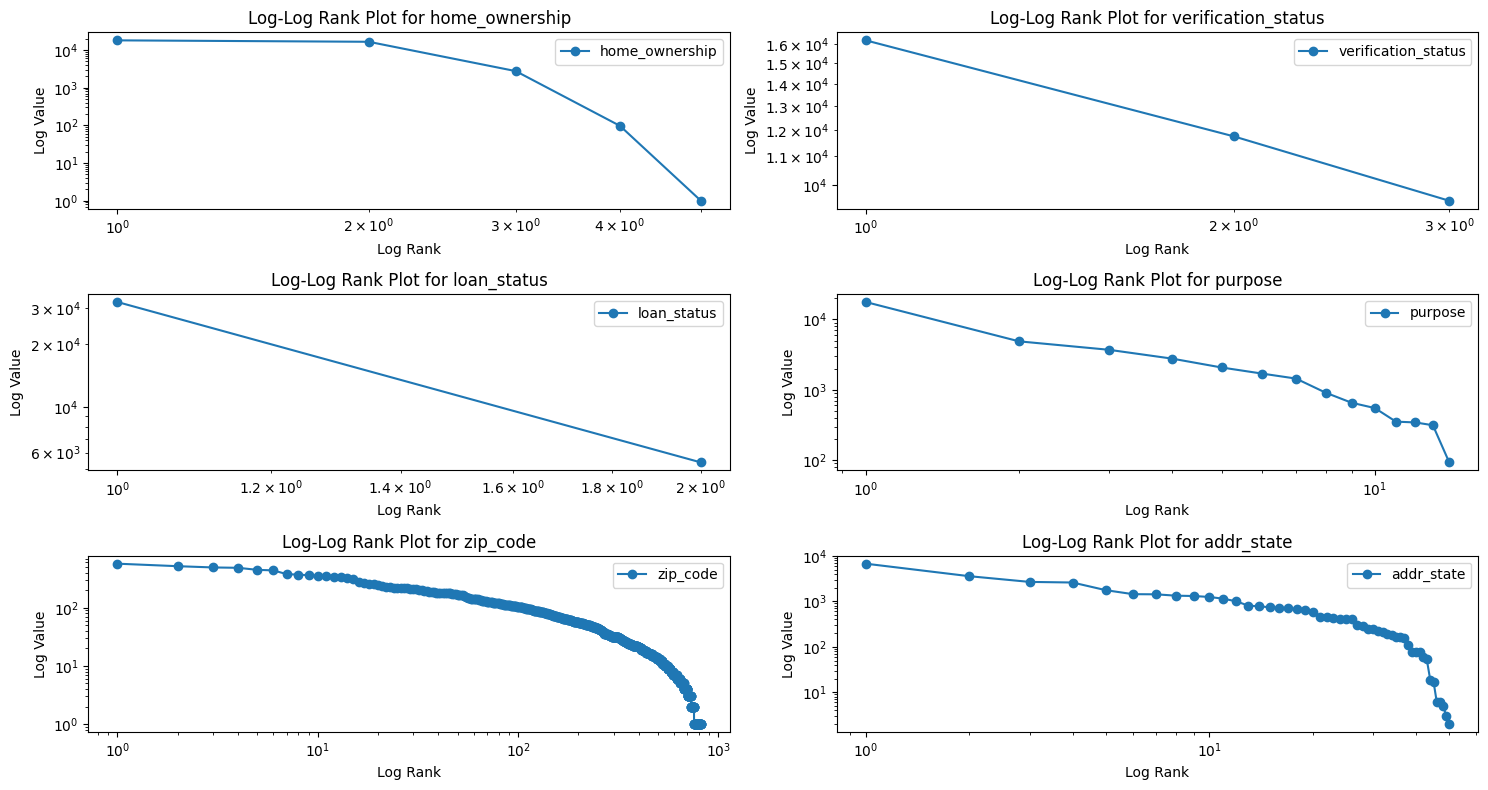

In [255]:
categorical_unordered = ['home_ownership', 'verification_status', 'loan_status', 'purpose', 'zip_code', 'addr_state']
nrows = math.ceil(len(categorical_unordered) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 8))
for i, column in enumerate(categorical_unordered):
    # Rank Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sorted_values = df_loan[column].value_counts().sort_values(ascending=False)
    ranks = range(1, len(sorted_values) + 1)
    axes[row, col].loglog(ranks, sorted_values, marker='o', linestyle='-', label=f'{column}')
    axes[row, col].set_title(f'Log-Log Rank Plot for {column}')
    axes[row, col].set_xlabel('Log Rank')
    axes[row, col].set_ylabel('Log Value')
    axes[row, col].legend()

# Remove empty subplots if the grid has more cells than needed
for j in range(len(categorical_unordered), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### From the above rank log-log plot, it can be concluded that except in certain part of plot, all categorical unordered variables are following power distribution law.

#### Univariate Analysis for Categorical Ordered Variable

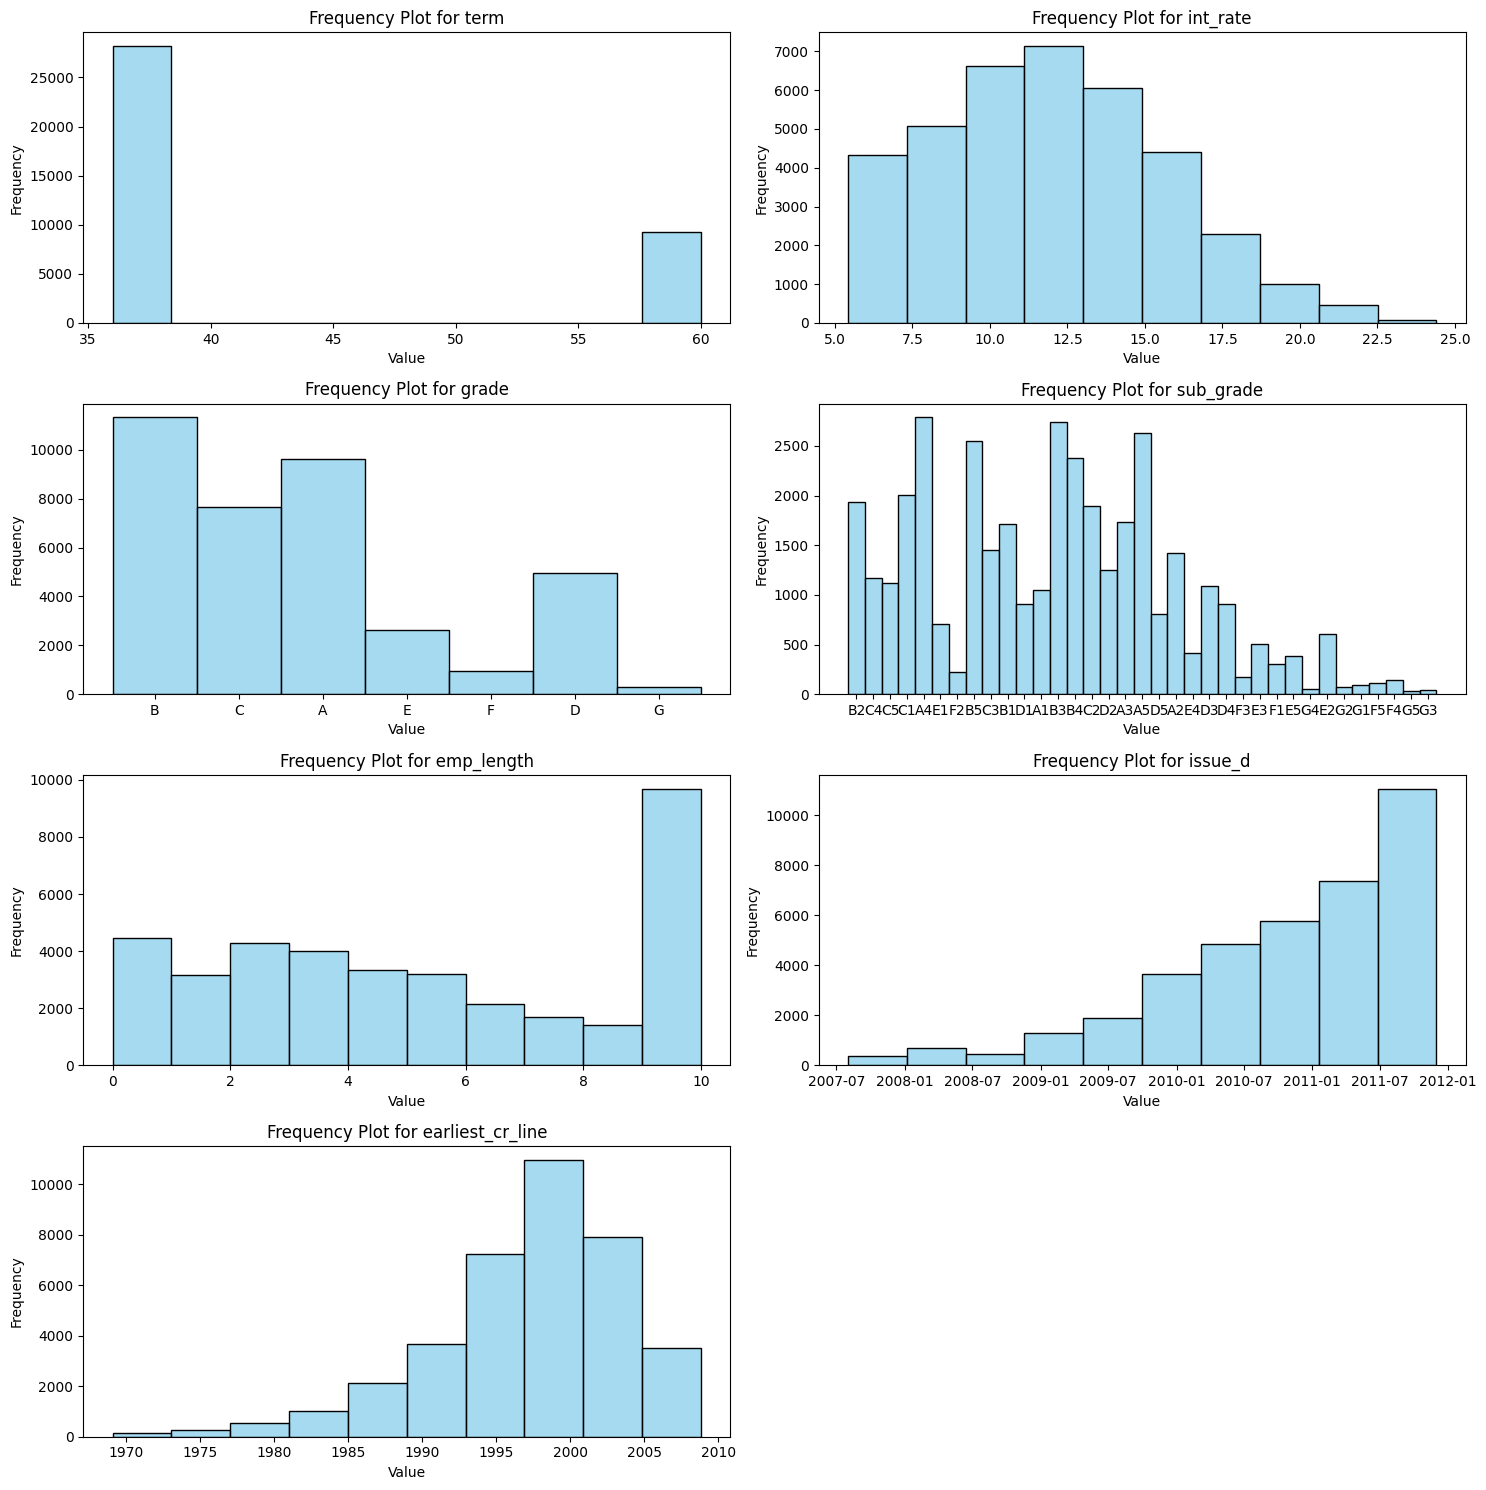

In [256]:
categorical_ordered = ['term', 'int_rate', 'grade', 'sub_grade', 'emp_length', 'issue_d', 'earliest_cr_line']
nrows = math.ceil(len(categorical_ordered) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 15))
for i, column in enumerate(categorical_ordered):
    # Frequency Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sns.histplot(df_loan[column], bins=10, kde=False, ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Frequency Plot for {column}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Remove empty subplots if the grid has more cells than needed
for j in range(len(categorical_ordered), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### Insights that we can come up from above histogram:
- <b>Term plot(term)</b>: Maximum loans are duration of 3 years. Low duration mean low risk of default. Bank can approach to those customers who have either fully paid their loan or near the end of loan duration.
- <b>Interest Rate plot(int_rate)</b>: Maximum loans lies in intereset rate range 9 - 15%. It should be analyzed to what kind of customers interst rate lower than 9 or higher than 15 is offered. Instead of 9 or 15 we can consider quartile 1 and quartile 3 for comparison. May be higher interest rate was offered to customer having bad track record and lower interest rate to customers having good track record.
- <b>Grade plot(grade)</b>: Most of the A or B grade customers are assigned loan. This shows that bank is interested in alloting loans to only those customers having very low risk. It could be further analyzed that what common in customers having grade higher than B (C, D, E, F, or G) due to which bank provided them loan and can they be risk for further loans.
- <b>Sub-grade plot(sub_grade)</b>: As we can see that A4, B5 are alloted loan in large number than A1. One hypothesis is that out of all the customers applying for loan in bank, very few are of A1 as compare to A4, B5. Otherwise based on grade analysis bank would not reject A1 applications.
- <b>Employee Length(emp_length)</b>: Bank is preferring those customers more who have high employee length. However there are also customers which have low employee length. These customers could be potential risk for bank for current and future loans.
- <b>Issue Date(issue_d)</b>: With time loan applications are increasing. This could be due to various factors like economic conditions, bank policies, or changes in lending practices.
- <b>Earliest Credit Lines(earliest_cr_line)</b>: Most of the customers has credit history between 1990 to 2010.

#### Univariate Analysis for Quantitative Variables

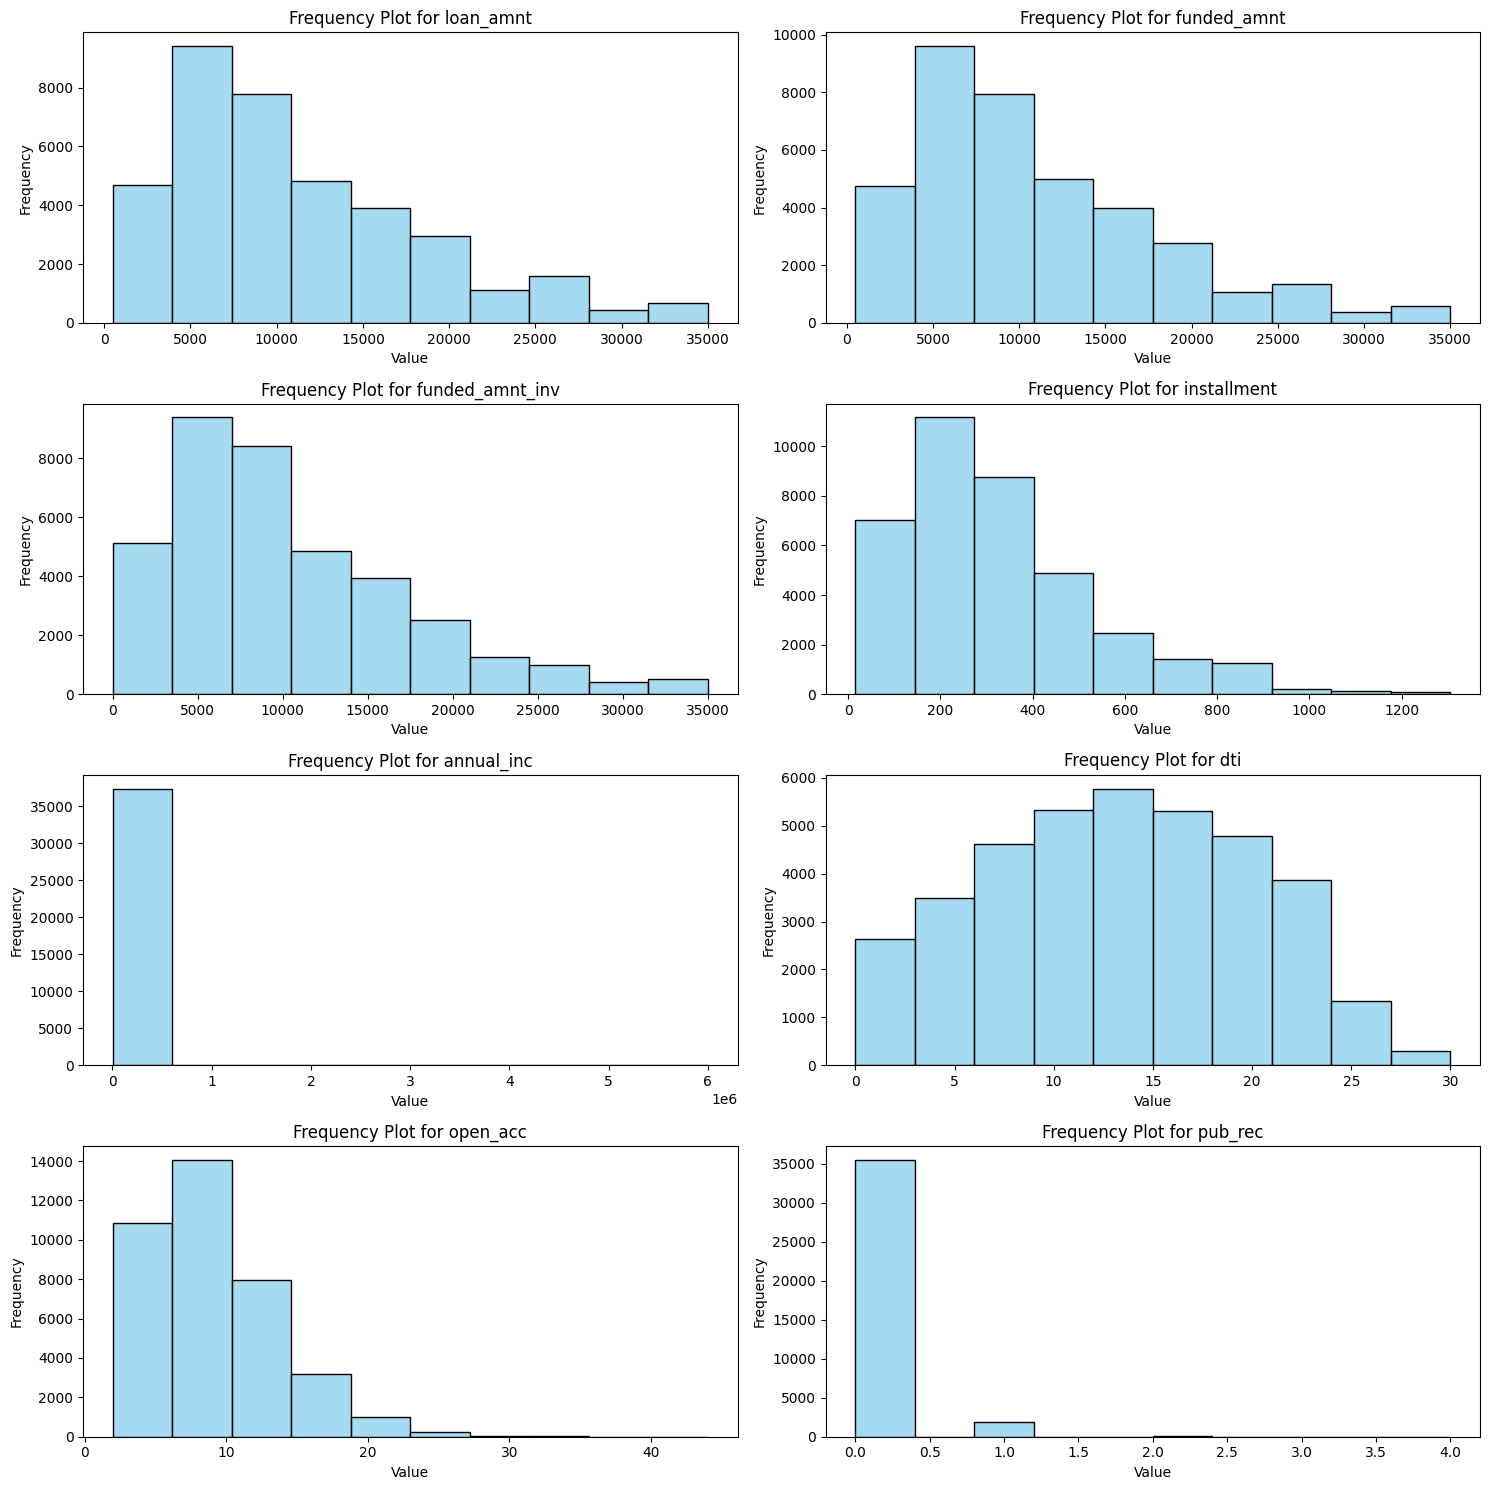

In [257]:
quantitative = ['loan_amnt',
'funded_amnt',
'funded_amnt_inv',
'installment',
'annual_inc',
'dti',
'open_acc',
'pub_rec']

ncols = 2
nrows = math.ceil(len(quantitative) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
for i, column in enumerate(quantitative):
    # Frequency Plot
    row = i // ncols  # Calculate the row index
    col = i % ncols   # Calculate the column index
    sns.histplot(df_loan[column], bins=10, kde=False, ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'Frequency Plot for {column}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Remove empty subplots if the grid has more cells than needed
for j in range(len(quantitative), nrows * ncols):
    row = j // ncols
    col = j % ncols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

##### Insights that we can come up from above histogram:
- <b>Loan Amount(loan_amnt)</b>: Most loans request falls between 5000-15000. High loan requests are less common. High loan amounts indicate greater risk.
- <b>Loan Amount Disbursed(funded_amnt)</b>: Follows a similar distribution as loan_amnt. This indicates efficient loan approval process as bank tends to fund amount close to loan amount requested.
- <b>Loan Amount Disbursed from Bank Investor(funded_amnt_inv)</b>: Follows a similar distribution as funded_amnt. This indicates investors has strong belief on bank and tends to fund amount close to loan amount requested.
- <b>Monthly Installment(installment)</b>: Most of the EMIs lies between 200-500. High EMIs might correlate with large loans and can impact borrower ability to repay.
- <b>Annual Income(annual_inc)</b>: Most customers contains income less than 200000 but there are <u>outliers</u> in data. 
- <b>Debt to Income Ratio(dti)</b>: Its value is less than 30 which indicates that bank grant loan to customers having low DTI as high DTI reflects high risk.
- <b>Open Credit Accounts(open_acc)</b>: Most customer has 1-15 opened credit accounts. More no. of credits represents more risk associated with customer.
- <b>Derrogatory Public Records(pub_rec)</b>: Almost all borrowers have zero public records, indicating good financial behavior. A small subset with 1 or more public records could be flagged as potentially higher risk.

##### Summary Metrics
<table border="1">
  <thead>
    <tr>
      <th>Quantitative Variables</th>
      <th>Mean</th>
      <th>Median (50 Percentile)</th>
      <th>25 Percentile</th>
      <th>75 Percentile</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>loan_amnt</td>
      <td>11304.94</td>
      <td>10000</td>
      <td>5600</td>
      <td>15000</td>
    </tr>
    <tr>
      <td>funded_amnt</td>
      <td>11030.01</td>
      <td>10000</td>
      <td>5500</td>
      <td>15000</td>
    </tr>
    <tr>
      <td>funded_amnt_inv</td>
      <td>10598.66</td>
      <td>9200</td>
      <td>5000</td>
      <td>14500</td>
    </tr>
    <tr>
      <td>installment</td>
      <td>326.11</td>
      <td>283.2</td>
      <td>168.9</td>
      <td>431.77</td>
    </tr>
    <tr>
      <td>annual_inc</td>
      <td>69278.08</td>
      <td>60000</td>
      <td>42000</td>
      <td>83000</td>
    </tr>
    <tr>
      <td>dti</td>
      <td>13.44</td>
      <td>13.54</td>
      <td>8.36</td>
      <td>18.69</td>
    </tr>
    <tr>
      <td>open_acc</td>
      <td>9.35</td>
      <td>9</td>
      <td>6</td>
      <td>12</td>
    </tr>
    <tr>
      <td>pub_rec</td>
      <td>0.05</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
  </tbody>
</table>d>3457.66</td>
    </tr>
    <tr>
      <td>pub_rec_bankruptcies</td>
      <td>0.04</td>
      <td>0</td>
      <td>0</td>
      <td>0</td>
    </tr>
  </tbody>
</table>


#### Segmented Univariate Analysis

##### We will be creating pivot table in excel for every quantitative variable against every categorical variable and observe trend in data. As it is difficult to show pivot table, We will be demonstrating HTML table for better understanding.

In [258]:
# In order to analyze against these target variables let's export loan data to excel
df_loan.to_excel('processed_loan.xlsx', index=False)

##### Term Variable Analysis
<table border="1">
  <thead>
    <tr>
      <th>Metric</th>
      <th>Term (Months)</th>
      <th>Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Sum of loan_amnt</td>
      <td>36</td>
      <td>253789550</td>
    </tr>
    <tr>
      <td>Sum of loan_amnt</td>
      <td>60</td>
      <td>157495475</td>
    </tr>
    <tr>
      <td>Sum of funded_amnt</td>
      <td>36</td>
      <td>250469475</td>
    </tr>
    <tr>
      <td>Sum of funded_amnt</td>
      <td>60</td>
      <td>150813425</td>
    </tr>
    <tr>
      <td>Average of funded_amnt</td>
      <td>36</td>
      <td>9509.1</td>
    </tr>
    <tr>
      <td>Average of funded_amnt</td>
      <td>60</td>
      <td>15019.8</td>
    </tr>
    <tr>
      <td>Sum of funded_amnt_inv</td>
      <td>36</td>
      <td>238182412.7</td>
    </tr>
    <tr>
      <td>Sum of funded_amnt_inv</td>
      <td>60</td>
      <td>147407560.2</td>
    </tr>
    <tr>
      <td>Average of installment</td>
      <td>36</td>
      <td>313.0602267</td>
    </tr>
    <tr>
      <td>Average of installment</td>
      <td>60</td>
      <td>360.3448481</td>
    </tr>
    <tr>
      <td>Average of annual_inc</td>
      <td>36</td>
      <td>67363.92</td>
    </tr>
    <tr>
      <td>Average of annual_inc</td>
      <td>60</td>
      <td>74299.37</td>
    </tr>
    <tr>
      <td>Average of dti</td>
      <td>36</td>
      <td>13.11655315</td>
    </tr>
    <tr>
      <td>Average of dti</td>
      <td>60</td>
      <td>14.29916642</td>
    </tr>
    <tr>
      <td>Sum of delinq_2yrs</td>
      <td>36</td>
      <td>3787</td>
    </tr>
    <tr>
      <td>Sum of delinq_2yrs</td>
      <td>60</td>
      <td>1530</td>
    </tr>
    <tr>
      <td>Sum of inq_last_6mths</td>
      <td>36</td>
      <td>22050</td>
    </tr>
    <tr>
      <td>Sum of inq_last_6mths</td>
      <td>60</td>
      <td>9429</td>
    </tr>
    <tr>
      <td>Sum of open_acc</td>
      <td>36</td>
      <td>242762</td>
    </tr>
    <tr>
      <td>Sum of open_acc</td>
      <td>60</td>
      <td>97391</td>
    </tr>
    <tr>
      <td>Sum of pub_rec</td>
      <td>36</td>
      <td>1377</td>
    </tr>
    <tr>
      <td>Sum of pub_rec</td>
      <td>60</td>
      <td>569</td>
    </tr>
    <tr>
      <td>Sum of revol_bal</td>
      <td>36</td>
      <td>335748645</td>
    </tr>
    <tr>
      <td>Sum of revol_bal</td>
      <td>60</td>
      <td>153760855</td>
    </tr>
    <tr>
      <td>Average of revol_util</td>
      <td>36</td>
      <td>48.07548975</td>
    </tr>
    <tr>
      <td>Average of revol_util</td>
      <td>60</td>
      <td>52.42150383</td>
    </tr>
    <tr>
      <td>Sum of total_acc</td>
      <td>36</td>
      <td>568458</td>
    </tr>
    <tr>
      <td>Sum of total_acc</td>
      <td>60</td>
      <td>240680</td>
    </tr>
    <tr>
      <td>Sum of out_prncp</td>
      <td>36</td>
      <td>0</td>
    </tr>
    <tr>
      <td>Sum of out_prncp</td>
      <td>60</td>
      <td>1910652.33</td>
    </tr>
    <tr>
      <td>Sum of out_prncp_inv</td>
      <td>36</td>
      <td>0</td>
    </tr>
    <tr>
      <td>Sum of out_prncp_inv</td>
      <td>60</td>
      <td>1901457.41</td>
    </tr>
    <tr>
      <td>Sum of total_pymnt</td>
      <td>36</td>
      <td>274615268.3</td>
    </tr>
    <tr>
      <td>Sum of total_pymnt</td>
      <td>60</td>
      <td>173154776.9</td>
    </tr>
    <tr>
      <td>Sum of total_pymnt_inv</td>
      <td>36</td>
      <td>261612697.6</td>
    </tr>
    <tr>
      <td>Sum of total_pymnt_inv</td>
      <td>60</td>
      <td>169068544.6</td>
    </tr>
    <tr>
      <td>Sum of total_rec_prncp</td>
      <td>36</td>
      <td>235338642.9</td>
    </tr>
    <tr>
      <td>Sum of total_rec_prncp</td>
      <td>60</td>
      <td>125233871</td>
    </tr>
    <tr>
      <td>Sum of total_rec_int</td>
      <td>36</td>
      <td>37954083.11</td>
    </tr>
    <tr>
      <td>Sum of total_rec_int</td>
      <td>60</td>
      <td>45845979.53</td>
    </tr>
    <tr>
      <td>Sum of total_rec_late_fee</td>
      <td>36</td>
      <td>32374.05508</td>
    </tr>
    <tr>
      <td>Sum of total_rec_late_fee</td>
      <td>60</td>
      <td>14938.12267</td>
    </tr>
    <tr>
      <td>Sum of recoveries</td>
      <td>36</td>
      <td>1290170.635</td>
    </tr>
    <tr>
      <td>Sum of recoveries</td>
      <td>60</td>
      <td>2059988.889</td>
    </tr>
    <tr>
      <td>Average of collection_recovery_fee</td>
      <td>36</td>
      <td>8.494082965</td>
    </tr>
    <tr>
      <td>Average of collection_recovery_fee</td>
      <td>60</td>
      <td>19.55767904</td>
    </tr>
    <tr>
      <td>Average of last_pymnt_amnt</td>
      <td>36</td>
      <td>2089.463257</td>
    </tr>
    <tr>
      <td>Average of last_pymnt_amnt</td>
      <td>60</td>
      <td>4458.414987</td>
    </tr>
    <tr>
      <td>Sum of pub_rec_bankruptcies</td>
      <td>36</td>
      <td>1035</td>
    </tr>
    <tr>
      <td>Sum of pub_rec_bankruptcies</td>
      <td>60</td>
      <td>465</td>
    </tr>
  </tbody>
</table> of pub_rec_bankruptcies</td>
            <td>36</td>
            <td>1035</td>
        </tr>
        <tr>
            <td>Sum of pub_rec_bankruptcies</td>
            <td>60</td>
            <td>465</td>
        </tr>
    </tbody>
</table>


##### Insights from above data
- More customers are opting for 3 year(36 month) loan than 5 year(60 month) loan
- Average EMI and funded amount is higher for 5 year loan which indicates that customer opting for high loan amount must be opting for 5 year tenure
- As customer opting for 3 year tenure taking small loans which means they cannot repay more because their average income is less than customers opting for 5 year tenure.
- Debit to Income ratio is almost similar, this is clear indicator that customer taking small loans are from small income bracket and mostly choose 3 year tenure while customer taking large loans are from high income bracket and mostly choose 5 year tenure.
- 3 year term customers are showing high delinquishing, high loan inquiries, large number of credit accounts, large number of public records(bankrupty, tax lien or judgements), high late recovering fee despite having low collection recovery fee, this segment is highly risky segment for bank to grant loan. It look like that lower income customers taking lot of credits in order to fulfill expense and ending with debt trap.
- In 5 year term, we can see outstanding principal. Our hypothesis is that it could be because of some defaults and some due to large loan amount.

##### Conclusion
- Bank should give 5 year tenure/term customers high priority over the 3 year tenure. In Bivariant analysis we can see correlation between term and annual income. 

<hr/>

##### int_rate
<p>Interest rate is not impacting risk of default. There are instances where customers default at relativly lower interest rate but there is no default on high interest rate</p>

<hr/>

##### grade and sub_grade
<table>
        <thead>
            <tr>
                <th>Metric</th>
                <th>A</th>
                <th>B</th>
                <th>C</th>
                <th>D</th>
                <th>E</th>
                <th>F</th>
                <th>G</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Sum of loan_amnt</td>
                <td>8,00,99,650.00</td>
                <td>12,31,56,975.00</td>
                <td>8,21,98,000.00</td>
                <td>5,99,36,975.00</td>
                <td>4,18,28,825.00</td>
                <td>1,79,91,850.00</td>
                <td>60,72,750.00</td>
            </tr>
            <tr>
                <td>Sum of funded_amnt</td>
                <td>7,79,59,100.00</td>
                <td>12,02,48,100.00</td>
                <td>8,05,23,625.00</td>
                <td>5,89,36,325.00</td>
                <td>4,03,17,425.00</td>
                <td>1,73,25,050.00</td>
                <td>59,73,275.00</td>
            </tr>
            <tr>
                <td>Average of funded_amnt2</td>
                <td>8,508.96</td>
                <td>10,911.81</td>
                <td>10,853.70</td>
                <td>12,106.89</td>
                <td>15,237.12</td>
                <td>17,897.78</td>
                <td>20,044.55</td>
            </tr>
            <tr>
                <td>Sum of funded_amnt_inv</td>
                <td>7,61,18,432.40</td>
                <td>11,57,85,293.46</td>
                <td>7,62,34,476.06</td>
                <td>5,63,65,398.26</td>
                <td>3,86,38,268.27</td>
                <td>1,67,30,095.83</td>
                <td>57,18,008.64</td>
            </tr>
            <tr>
                <td>Average of installment</td>
                <td>259.91</td>
                <td>321.73</td>
                <td>320.94</td>
                <td>363.37</td>
                <td>426.78</td>
                <td>501.84</td>
                <td>578.46</td>
            </tr>
            <tr>
                <td>Average of annual_inc</td>
                <td>67,304.99</td>
                <td>67,668.23</td>
                <td>68,183.22</td>
                <td>68,838.47</td>
                <td>78,117.21</td>
                <td>84,883.13</td>
                <td>94,736.42</td>
            </tr>
            <tr>
                <td>Average of dti</td>
                <td>12.18</td>
                <td>13.55</td>
                <td>14.00</td>
                <td>14.12</td>
                <td>14.14</td>
                <td>14.31</td>
                <td>14.19</td>
            </tr>
            <tr>
                <td>Sum of delinq_2yrs</td>
                <td>399.00</td>
                <td>1,272.00</td>
                <td>1,379.00</td>
                <td>1,195.00</td>
                <td>629.00</td>
                <td>320.00</td>
                <td>123.00</td>
            </tr>
            <tr>
                <td>Sum of inq_last_6mths</td>
                <td>6,207.00</td>
                <td>8,572.00</td>
                <td>7,988.00</td>
                <td>4,791.00</td>
                <td>2,589.00</td>
                <td>1,037.00</td>
                <td>295.00</td>
            </tr>
            <tr>
                <td>Sum of open_acc</td>
                <td>86,873.00</td>
                <td>1,01,731.00</td>
                <td>68,207.00</td>
                <td>44,958.00</td>
                <td>25,272.00</td>
                <td>9,897.00</td>
                <td>3,215.00</td>
            </tr>
            <tr>
                <td>Sum of pub_rec</td>
                <td>129.00</td>
                <td>577.00</td>
                <td>550.00</td>
                <td>369.00</td>
                <td>210.00</td>
                <td>88.00</td>
                <td>23.00</td>
            </tr>
            <tr>
                <td>Sum of revol_bal</td>
                <td>10,44,55,084.00</td>
                <td>14,84,17,472.00</td>
                <td>10,14,60,083.00</td>
                <td>6,90,54,031.00</td>
                <td>4,29,72,638.00</td>
                <td>1,69,37,498.00</td>
                <td>62,12,694.00</td>
            </tr>
            <tr>
                <td>Average of revol_util</td>
                <td>30.19</td>
                <td>46.87</td>
                <td>56.83</td>
                <td>63.20</td>
                <td>68.02</td>
                <td>70.11</td>
                <td>75.41</td>
            </tr>
            <tr>
                <td>Sum of total_acc</td>
                <td>2,15,976.00</td>
                <td>2,43,181.00</td>
                <td>1,57,684.00</td>
                <td>1,02,756.00</td>
                <td>59,162.00</td>
                <td>23,180.00</td>
                <td>7,199.00</td>
            </tr>
            <tr>
                <td>Sum of out_prncp</td>
                <td>38,600.20</td>
                <td>5,35,094.21</td>
                <td>4,21,411.96</td>
                <td>3,64,346.67</td>
                <td>3,25,950.79</td>
                <td>1,81,752.21</td>
                <td>43,496.29</td>
            </tr>
            <tr>
                <td>Sum of total_pymnt</td>
                <td>8,36,84,019.79</td>
                <td>13,28,84,517.58</td>
                <td>9,04,17,554.55</td>
                <td>6,68,89,006.49</td>
                <td>4,68,08,288.53</td>
                <td>2,00,80,319.24</td>
                <td>70,06,339.08</td>
            </tr>
            <tr>
                <td>Sum of pub_rec_bankruptcies</td>
                <td>108.00</td>
                <td>468.00</td>
                <td>412.00</td>
                <td>264.00</td>
                <td>165.00</td>
                <td>66.00</td>
                <td>17.00</td>
            </tr>
        </tbody>
    </table>

##### Insights from grade data. Grade determine risk associated with customer. Customer had these grades when they applied for loan but it is possible that they no more holds the same grade. A stands for low risk and G stands for high risk:
- Although B grade stands for low risk, but based on data, B grade customers has high delinquishing, high loan inquiries, high credit accounts, high public records(bankruptcy, tax lien, judgement), high revolving account balance, high outstanding principal, high late fess despite having low recovery charges. Due to these factors, we can say that B grade customers are mostly risky.
- Collection recovery fees is increasing from A to G.
- Bank has disbursed largest amount of loan for B grade customers.

##### Conclusion
- B grade customers have become risky and may be many of them donot belongs to same grade. So Bank should take care before giving them loan. When you further drill down the data and see <b>sub_grade</b>, you will find that among B grade customer B3, B4 and B5 customers are most vulnerable.

<hr/>

##### In emp_title and emp_length there is no impact on risk. But there is a observation that bank has granted loans of large amount to 10 or more experienced customer more than to the less experienced customers. More loan queries are also coming from 10+ length customers and they have public records, outstanding principals, high credit accounts, which overall make this segment risky.

##### We can perform Bivariate analysis between emp_length and other metrics to determine exact correlation that can impact risk of default.

<hr/>

##### home_ownership
<table border="1">
  <thead>
    <tr>
      <th>Metric</th>
      <th>Category</th>
      <th>Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="4">Sum of loan_amnt</td>
      <td>MORTGAGE</td>
      <td>20,72,28,150.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>10,04,575.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,66,54,900.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>17,63,97,400.00</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of funded_amnt</td>
      <td>MORTGAGE</td>
      <td>20,12,34,075.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>9,54,175.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,60,86,200.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>17,30,08,450.00</td>
    </tr>
    <tr>
      <td rowspan="4">Average of funded_amnt2</td>
      <td>MORTGAGE</td>
      <td>12,366.89</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>10,259.95</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>10,162.13</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>9,915.09</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of funded_amnt_inv</td>
      <td>MORTGAGE</td>
      <td>19,34,94,868.37</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>6,92,236.42</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,52,16,965.75</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>16,61,85,902.40</td>
    </tr>
    <tr>
      <td rowspan="4">Average of installment</td>
      <td>MORTGAGE</td>
      <td>357.33</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>342.55</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>301.73</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>300.50</td>
    </tr>
    <tr>
      <td rowspan="4">Average of annual_inc</td>
      <td>MORTGAGE</td>
      <td>83,062.92</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>72,896.30</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>59,256.30</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>57,878.14</td>
    </tr>
    <tr>
      <td rowspan="4">Average of dti</td>
      <td>MORTGAGE</td>
      <td>13.26</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>11.39</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>13.48</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>13.62</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of delinq_2yrs</td>
      <td>MORTGAGE</td>
      <td>2,508.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>31.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>395.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>2,383.00</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of inq_last_6mths</td>
      <td>MORTGAGE</td>
      <td>15,541.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>102.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,300.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>13,536.00</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of open_acc</td>
      <td>MORTGAGE</td>
      <td>1,68,016.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>838.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>23,290.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>1,48,009.00</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of pub_rec</td>
      <td>MORTGAGE</td>
      <td>1,004.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>2.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>118.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>822.00</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of revol_bal</td>
      <td>MORTGAGE</td>
      <td>27,90,23,613.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>11,47,258.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>3,05,05,900.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>17,88,32,729.00</td>
    </tr>
    <tr>
      <td rowspan="4">Average of revol_util</td>
      <td>MORTGAGE</td>
      <td>47.02</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>43.85</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>45.12</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>52.02</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of total_acc</td>
      <td>MORTGAGE</td>
      <td>4,28,393.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>2,021.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>54,471.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>3,24,253.00</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of out_prncp</td>
      <td>MORTGAGE</td>
      <td>11,23,130.79</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>1,14,851.42</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>6,72,670.12</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of out_prncp_inv</td>
      <td>MORTGAGE</td>
      <td>11,16,237.74</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>1,14,377.46</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>6,70,842.21</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of total_pymnt</td>
      <td>MORTGAGE</td>
      <td>22,59,35,991.03</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>9,77,800.68</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,87,89,201.71</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>19,20,67,051.83</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of total_pymnt_inv</td>
      <td>MORTGAGE</td>
      <td>21,75,71,533.55</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>7,15,249.83</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,78,22,226.59</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>18,45,72,232.32</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of total_rec_prncp</td>
      <td>MORTGAGE</td>
      <td>18,13,19,741.64</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>8,07,746.35</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,34,06,448.57</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>15,50,38,577.31</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of total_rec_int</td>
      <td>MORTGAGE</td>
      <td>4,28,59,542.28</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>1,58,113.18</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>51,62,058.88</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>3,56,20,348.30</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of total_rec_late_fee</td>
      <td>MORTGAGE</td>
      <td>18,032.08</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>334.25</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>3,985.06</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>24,960.79</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of recoveries</td>
      <td>MORTGAGE</td>
      <td>17,38,676.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>11,606.98</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,16,709.44</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>13,83,167.11</td>
    </tr>
    <tr>
      <td rowspan="4">Average of collection_recovery_fee</td>
      <td>MORTGAGE</td>
      <td>13.15</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>19.71</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>9.88</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>10.26</td>
    </tr>
    <tr>
      <td rowspan="4">Average of last_pymnt_amnt</td>
      <td>MORTGAGE</td>
      <td>3,255.91</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>1,803.70</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>2,663.98</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>2,281.91</td>
    </tr>
    <tr>
      <td rowspan="4">Sum of pub_rec_bankruptcies</td>
      <td>MORTGAGE</td>
      <td>797.00</td>
    </tr>
    <tr>
      <td>OTHER</td>
      <td>2.00</td>
    </tr>
    <tr>
      <td>OWN</td>
      <td>89.00</td>
    </tr>
    <tr>
      <td>RENT</td>
      <td>612.00</td>
    </tr>
  </tbody>
</table><td>2.00</td></tr>
        <tr><td>OWN</td><td>89.00</td></tr>
        <tr><td>RENT</td><td>612.00</td></tr>
    </tbody>
</table>


##### From the above analysis, following insights can be said:
- MORTGAGE and RENT are high risk home ownership, as they have high public records, high credit accounts, high outstanding principal, high recoveries, high revolving balance, high loan inquiries. But at the same time these segments provide high interest to bank as well.
- Assuming in MORTGAGE, asset is mortgaged to bank, so it become less risky and more profitable. So Bank can target MORTGAGE customers over any other category of home_ownership. Apart from average annual income of MORTGAGE customers is higher than other segment customers.

##### Conclusion
- Assuming in MORTGAGE, asset is mortgaged to bank, so it become less risky and more profitable. So Bank can target MORTGAGE customers over any other category of home_ownership. Apart from average annual income of MORTGAGE customers is higher than other segment customers.

<hr/>

In [324]:
# Defining a function that will create a Bivariate analysis chart
def create_bivariate_chart(df, col_name, rot=0):
    # Group by the column and loan_status, then calculate the percentage of 'Charged Off' loans
    col_name_loan_status = df.groupby([col_name, 'loan_status']).size().unstack()
    col_name_loan_status['total'] = col_name_loan_status.sum(axis=1)
    col_name_loan_status['Percentage'] = (col_name_loan_status['Charged Off'] / col_name_loan_status['total']) * 100

    # Create a bar plot for the percentage of 'Charged Off' loans
    plt.figure(figsize=(15, 7))
    bars = col_name_loan_status['Percentage'].plot(kind='bar', color='skyblue')
    plt.xlabel(col_name)
    plt.ylabel('Percentage of Charged Off loans')
    plt.title(f'Percentage of Charged Off loans by {col_name}')
    plt.xticks(rotation=rot)

    # Add percentage labels on top of the bars
    for bar in bars.patches:
        plt.annotate(format(bar.get_height(), '.1f'),
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     ha='center', va='center', size=10, xytext=(0, 8),
                     textcoords='offset points')

    plt.show()


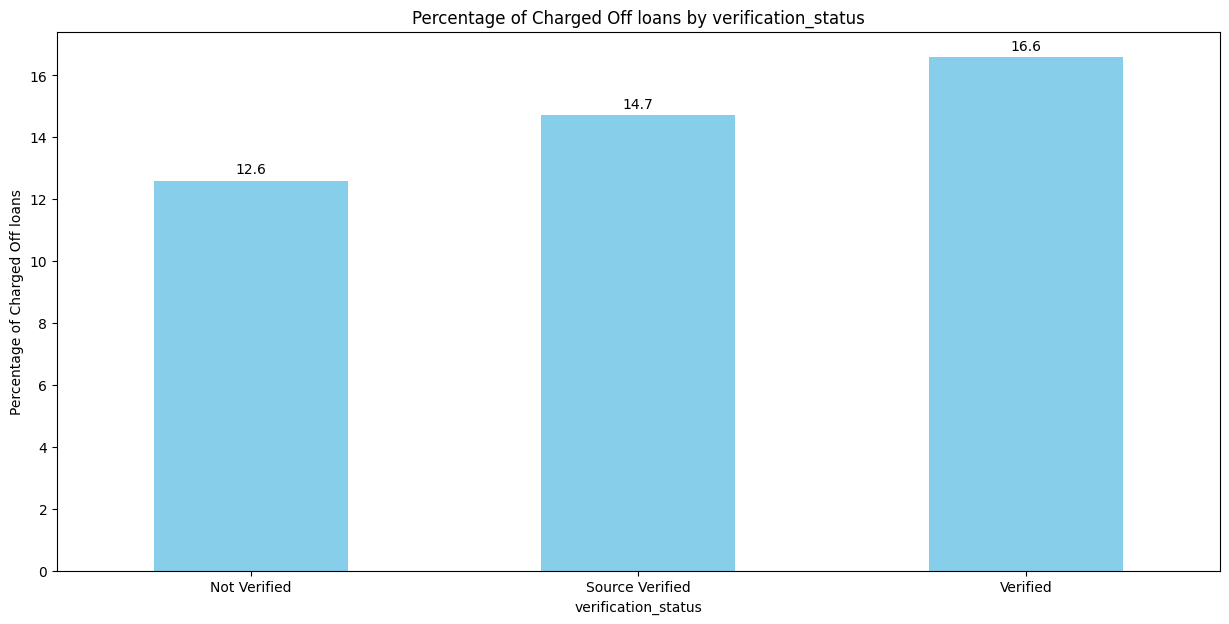

In [325]:
# Bivariate analysis of Verification Status and Loan Status
# verification_status_loan_status = df_loan.groupby(['verification_status', 'loan_status']).size().unstack()

create_bivariate_chart(df_loan, 'verification_status')

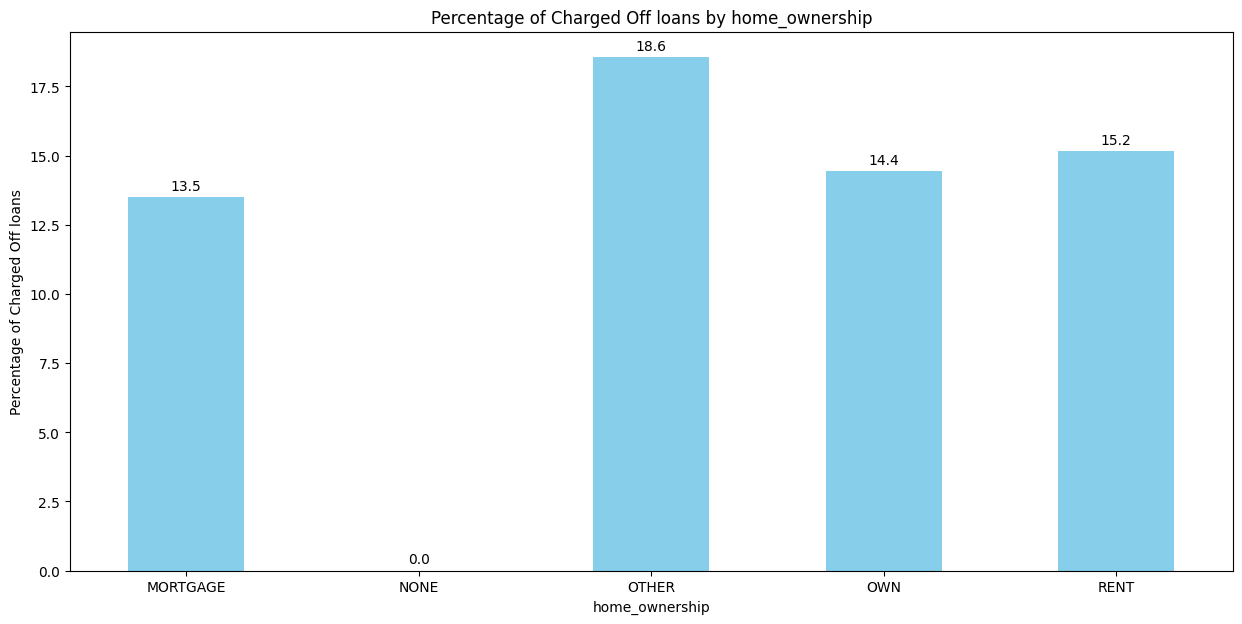

In [326]:
# Bivariate analysis of Home Ownership and Loan Status
create_bivariate_chart(df_loan, 'home_ownership')

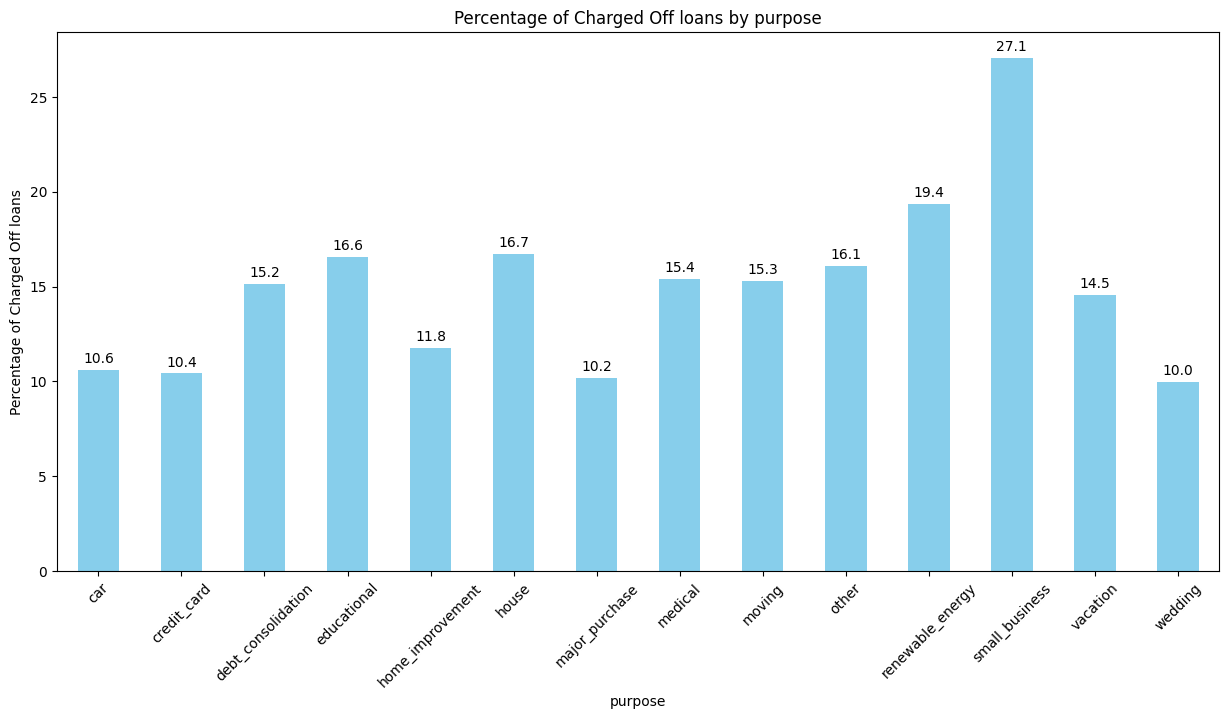

In [327]:
# Bivariate analysis of Purpose and Loan Status
create_bivariate_chart(df_loan, 'purpose', 45)

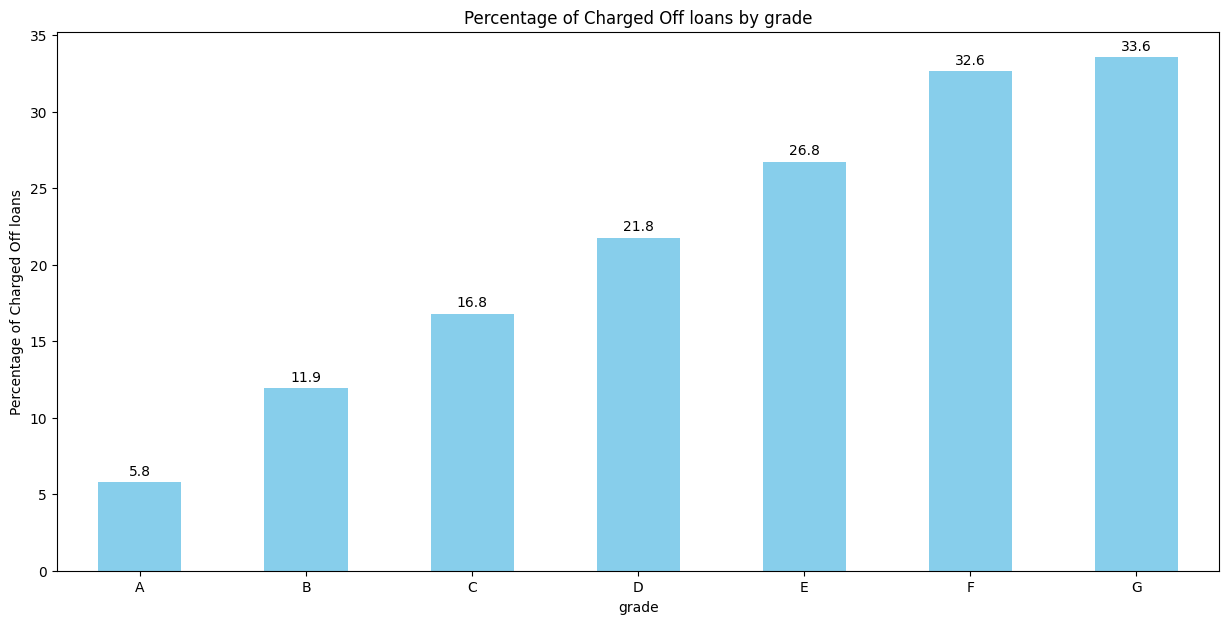

In [328]:
# Bivariate analysis of Grade and Loan Status
create_bivariate_chart(df_loan, 'grade')

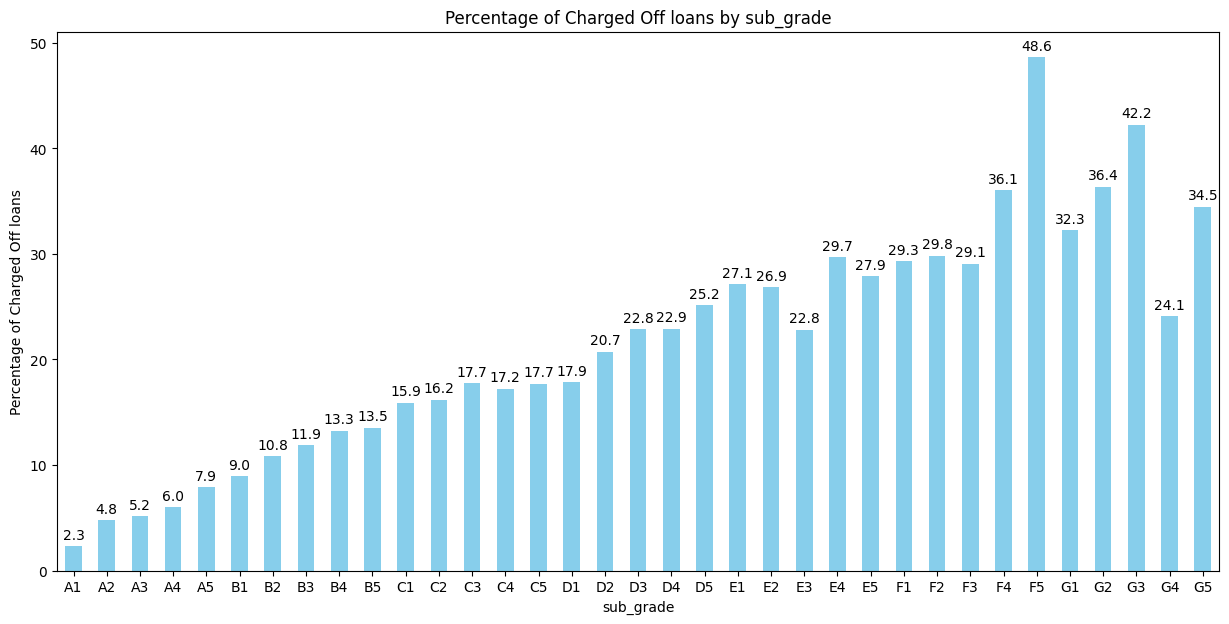

In [330]:
create_bivariate_chart(df_loan, 'sub_grade')

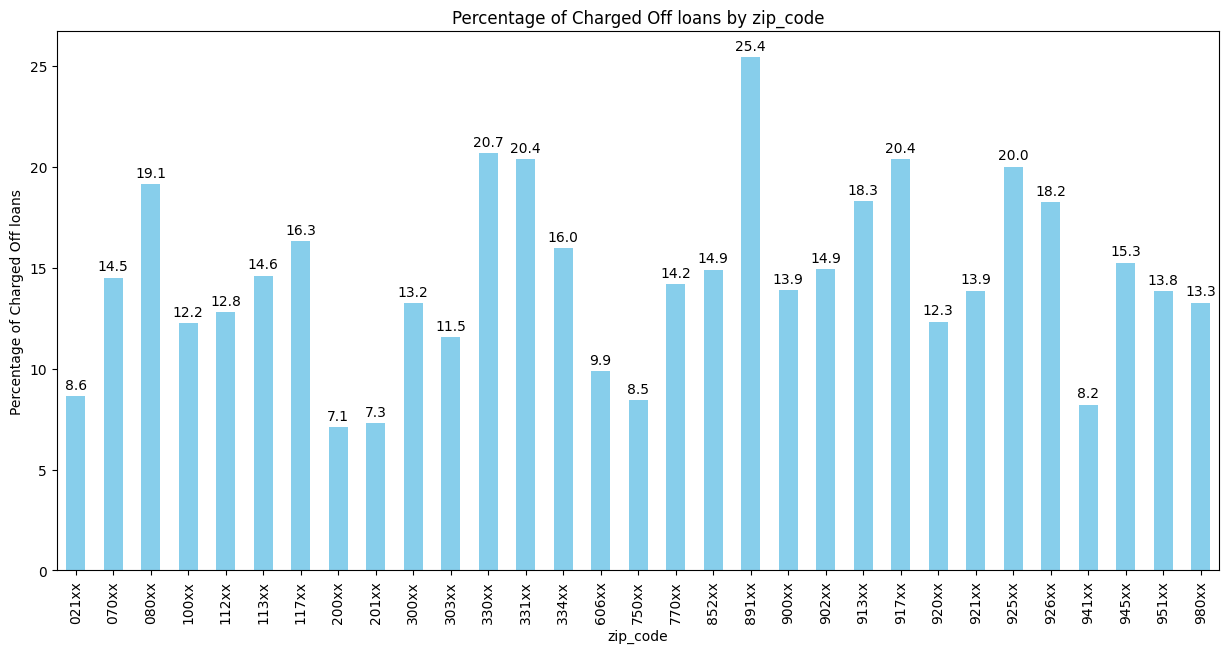

In [303]:
# fetch all the recods that contain zips that have more than 200 applications
zip_code = df_loan['zip_code'].value_counts()
zip_code = zip_code[zip_code > 200]
zip_code = zip_code.index
df_loan_zip_code = df_loan[df_loan['zip_code'].isin(zip_code)]
create_bivariate_chart(df_loan_zip_code, 'zip_code')

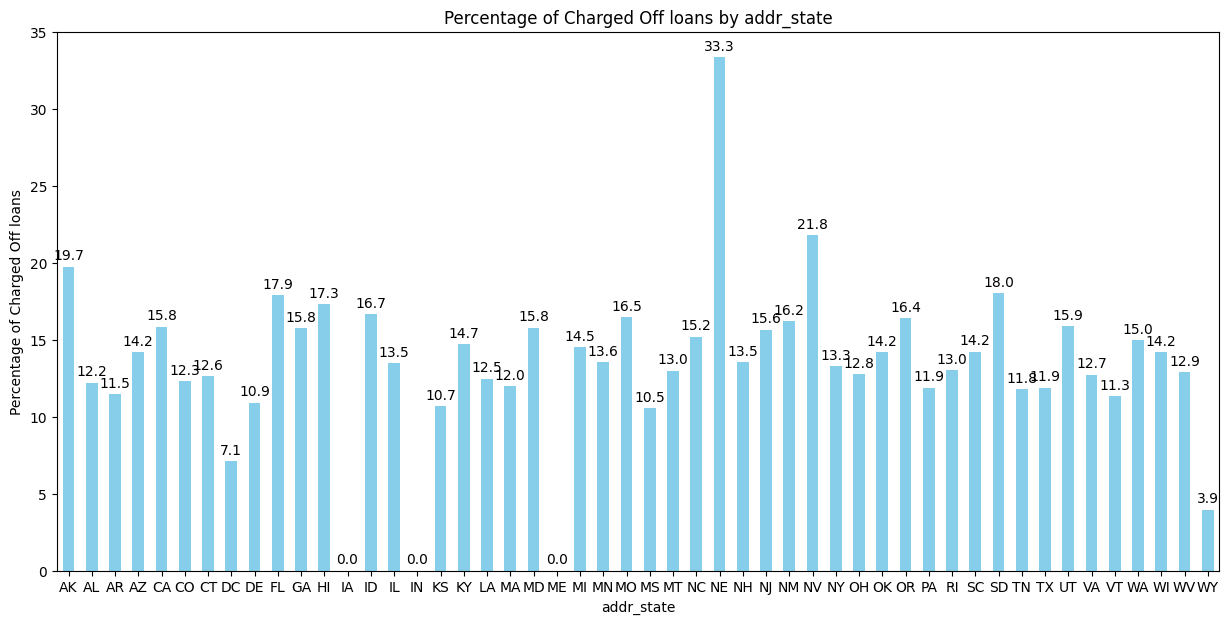

In [334]:
create_bivariate_chart(df_loan, 'addr_state')

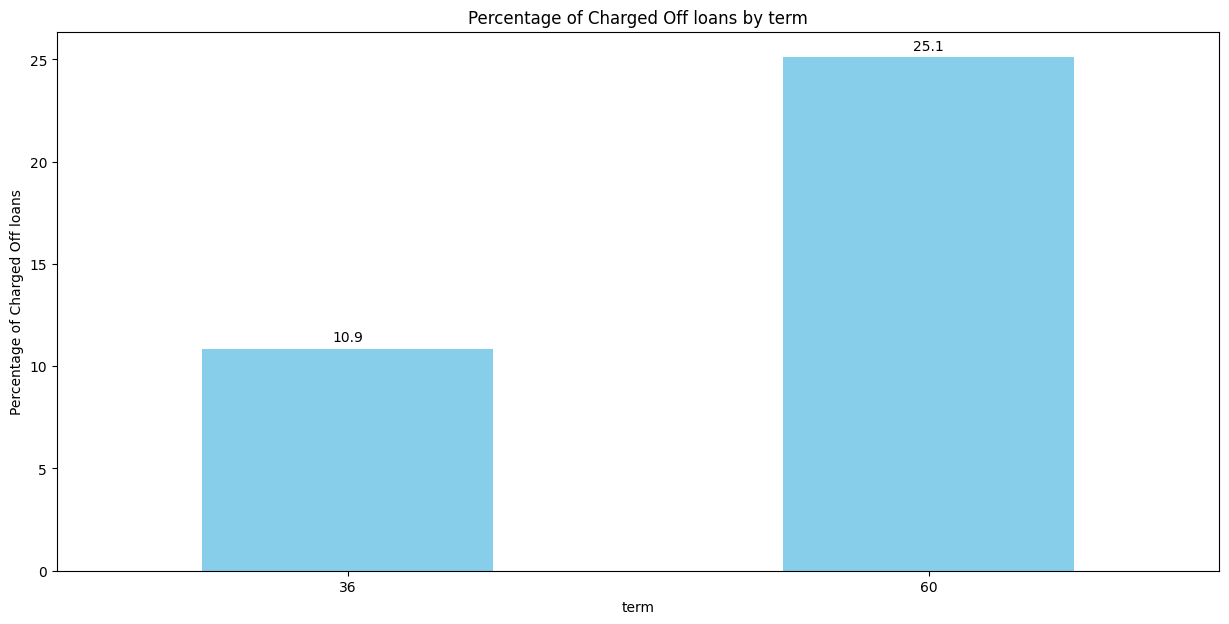

In [333]:
create_bivariate_chart(df_loan, 'term')

41000.0 60000.0 83000.0 125000.0


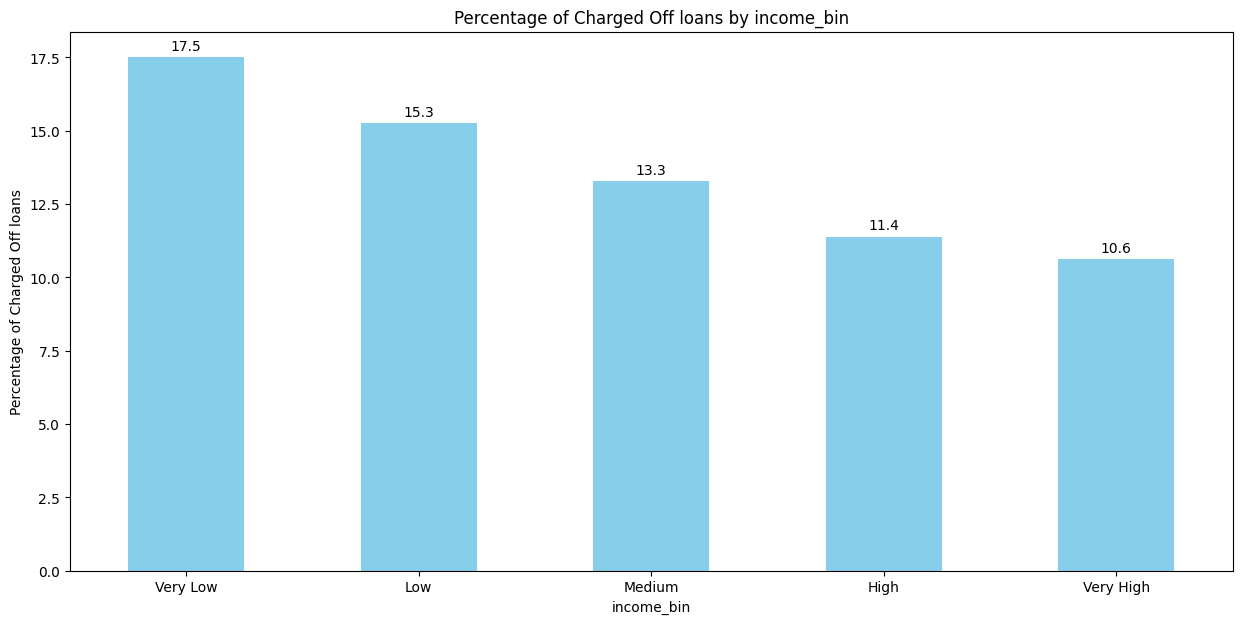

In [332]:
# Calculate quartiles and IQR
Q1 = df_loan['annual_inc'].quantile(0.25)
Q2 = df_loan['annual_inc'].quantile(0.50)
Q3 = df_loan['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q2, Q3, Q3 + IQR)

# Define bins based on the quartiles
bins = [0, Q1, Q2, Q3, Q3 + IQR, df_loan['annual_inc'].max()]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create a new column for income bins
df_loan['income_bin'] = pd.cut(df_loan['annual_inc'], bins=bins, labels=labels, include_lowest=True)

create_bivariate_chart(df_loan, 'income_bin', 0)

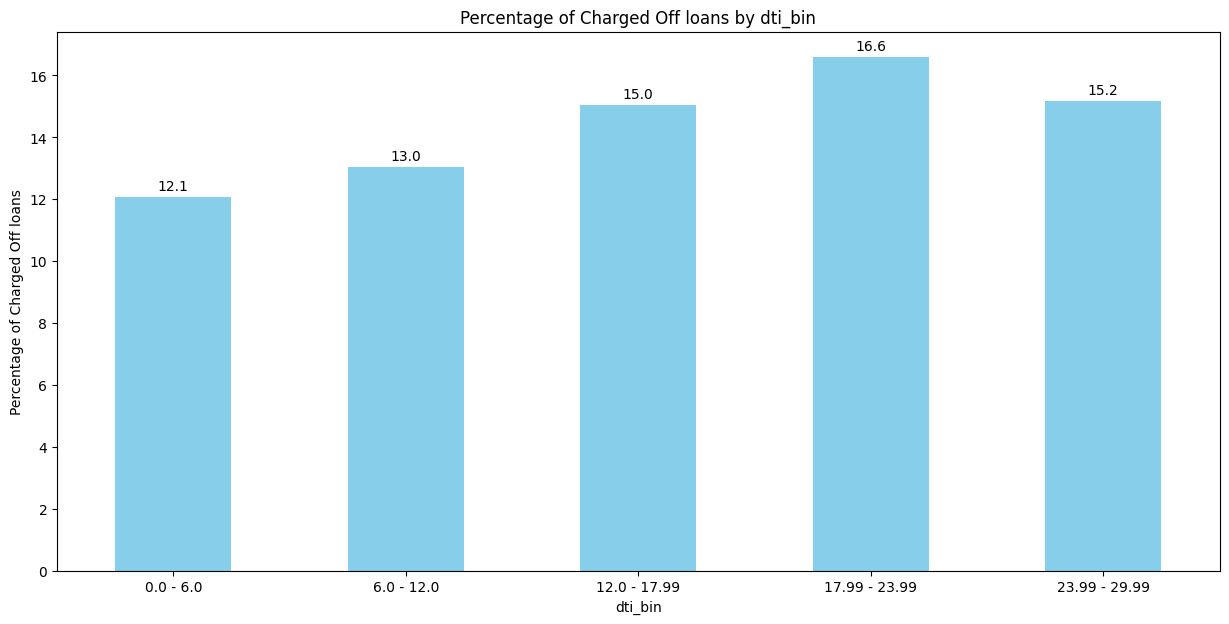

In [331]:
# Calculate quartiles and IQR
# Calculate min and max
min_dti = df_loan['dti'].min()
max_dti = df_loan['dti'].max()

# Define number of bins
num_bins = 5

# Create equal spaced bins
bins = np.linspace(min_dti, max_dti, num_bins + 1)
labels = [f'{round(bins[i], 2)} - {round(bins[i+1], 2)}' for i in range(num_bins)]

# Create a new column for dti bins
df_loan['dti_bin'] = pd.cut(df_loan['dti'], bins=bins, labels=labels, include_lowest=True)

create_bivariate_chart(df_loan, 'dti_bin')

5500.0 10000.0 15000.0 24500.0


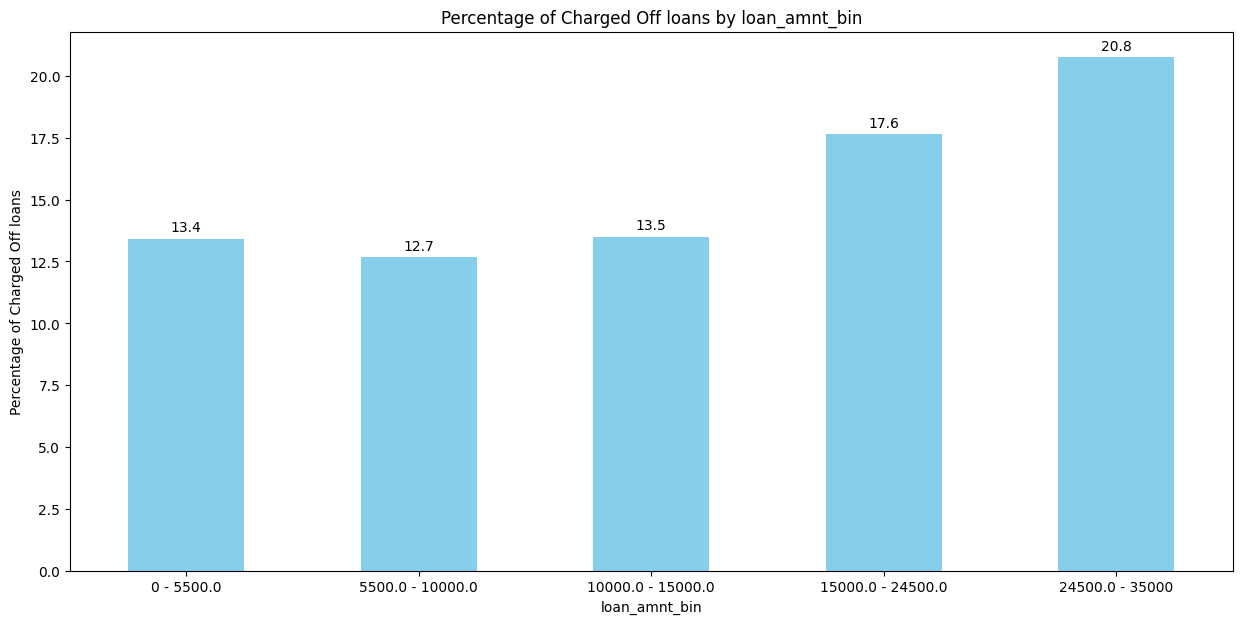

In [339]:
# Calculate quartiles and IQR
Q1 = df_loan['loan_amnt'].quantile(0.25)
Q2 = df_loan['loan_amnt'].quantile(0.50)
Q3 = df_loan['loan_amnt'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q2, Q3, Q3 + IQR)

# Define bins based on the quartiles
bins = [0, Q1, Q2, Q3, Q3 + IQR, df_loan['loan_amnt'].max()]
labels = [f'{round(bins[i], 2)} - {round(bins[i+1], 2)}' for i in range(num_bins)]

# Create a new column for income bins
df_loan['loan_amnt_bin'] = pd.cut(df_loan['loan_amnt'], bins=bins, labels=labels, include_lowest=True)

create_bivariate_chart(df_loan, 'loan_amnt_bin')